# Week 5: Economics of the Yield Curve


## FINM 37400: Fixed Income

### Mark Hendricks

#### Winter 2023

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings

pd.set_option("display.precision", 4)

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               StrMethodFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from portfolio import *

$\newcommand{\yield}{Y}$
$\newcommand{\logyield}{y}$
$\newcommand{\price}{P}$
$\newcommand{\logprice}{p}$
$\newcommand{\mat}{(n)}$

# What Determines the Shape of the Term Structure?

Many theories, including...
- Segmented markets. 
    - Long and short term bonds appeal to different investors, and they have differing supply and demand.
    - This theory seems at odds with the tight factor structure (high correlation) seen between bonds of different maturities. 
    - May be some truth for why there are small frictions between various maturities.
    
- Economic explanations
    - Liquidity preference theory
    - Representative agent models.
    - Not going to discuss these, as they are used more for macroeconomic theorizing, not pricing or managing financial products.

**The baseline theory is the Expectation Hypothesis**
- This theory is simplistic.
- It is empirically wrong.
- But it serves as a useful baseline in organizing the question.

## The Expectations Hypothesis (EH)

The **Expectations Hypothesis** has three equivalent forms. Conceptually, they are...

1. Long-term yields are the market's expectation of the average future short-term yields.

1. Forward rates are the optimal forecast of future (one-period) yields. 

1. Expected returns on holding bonds are equal across maturities. 


### Mathematically

1. The $n$-period yield is the average of expected one-period yields.

$\begin{align}
\logyield^{\mat}_t = \frac{1}{n}\mathbb{E}_t\left[\logyield^{(1)}_t + \logyield^{(1)}_{t+1} + \logyield^{(1)}_{t+2} + \ldots + \logyield^{(1)}_{t+n-1}\right]
\end{align}$

2. The forward rate is the market's expectation of the future spot rate:

$\begin{align}
f_t^{(n\to n+1)} = \mathbb{E}_t\left[y^{(1)}_{t+n}\right]
\end{align}$

3. For any maturity, $n$, the one-period expected return is the one-period yield.

$\begin{align}
\mathbb{E}_t\left[r_{t+1}^{\mat}\right] = y_t^{(1)}
\end{align}$


### Testable Implications

1. On average, all yields are equal.

2. The current forward rate and future short-yield should be equal on average.

3. For any maturity, average returns are equal, (to the risk-free rate.)

# Empirical Analysis of the EH

The EH doesn't hold, but the way in which it fails illustrates three important facts.

## Fact #1: 
### Long-term yields are higher than short-term yields--even averaged over long periods of time.
This means that long-term yields cannot simply be an average of short-term yields.

In [2]:
DATAPATH = '../data/treasury_zero_coupon.xlsx'
SHEET = 'prices'
prices = pd.read_excel(DATAPATH,sheet_name=SHEET).set_index('date')
prices.columns.name = 'maturity'

lprices = np.log(prices)
lyields = - lprices.copy() / lprices.columns.values.astype('float64')

In [3]:
EHtest1 = lyields.mean().to_frame().rename(columns={0:'mean yield'})
EHtest1.style.format('{:.2%}')

,mean yield
maturity,
1,4.57%
2,4.77%
3,4.95%
4,5.10%
5,5.21%


## Fact #2: 
### Forwards are higher on average than the future yield.

In [4]:
lforwards = -lprices.diff(axis=1)
lforwards[1] = -lprices[1]
lforwardsx = lforwards.subtract(lforwards[1],axis=0).drop(columns=[1])

In [5]:
EHtest2 = pd.DataFrame(columns=['$$f_t^{(n, n+1)}$$','$$y_{t+n}^{(1)}$$'],index=lforwards.columns,dtype=float)

for mat in EHtest2.index:
    temp = pd.concat([lforwards[mat].shift(mat), lyields[mat]],axis=1)
    EHtest2.loc[mat,:] = temp.mean().values

EHtest2['forward pred minus obs'] = EHtest2.iloc[:,0]- EHtest2.iloc[:,1]

EHtest2.style.format('{:.2%}')

,"$$f_t^{(n, n+1)}$$",$$y_{t+n}^{(1)}$$,forward pred minus obs
maturity,,,
1,4.58%,4.57%,0.01%
2,4.97%,4.77%,0.20%
3,5.32%,4.95%,0.37%
4,5.57%,5.10%,0.48%
5,5.66%,5.21%,0.46%


## Fact #3: 
### Excess returns are not zero.

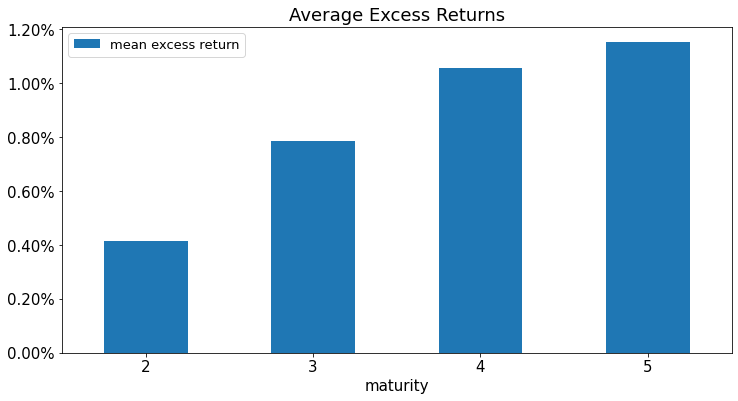

In [6]:
FREQ = 12

lrets = pd.DataFrame(columns=lprices.columns, index=lprices.index)
lrets.index.name = 'Log Returns'
lrets[1] = lyields[1].shift(FREQ)

for n in range(2,6):
    lrets[n] = lprices[n-1] - lprices[n].shift(FREQ)

lrets.dropna(inplace=True)
lretsx = lrets.subtract(lrets[1],axis=0).drop(columns=[1])

EHtest3 = lretsx.mean().to_frame().rename(columns={0:'mean excess return'})

ax = EHtest3.plot.bar(title='Average Excess Returns')
plt.xticks(rotation=0)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:.2%}'))
plt.show()

### Conclusion

The statistics above are evidence against the Expectations Hypothesis. 

Specifically,
1. Long-term yields do NOT equal average short-term yields. 
2. Forwards systematically overstate future yields.
3. Long-term bonds have excess returns.

# Dynamic Testing of the EH

## Fact #1: 
### The idea that today's 5-year rate is a forecast of future 1-year rates is supported by the data.

The empirical analysis above showed that...
- long-term yields overestimate future short rates
- Thus, the level of the forecast is incorrect.

Nonetheless, the **change** in long-term rates is indicative of **change** in future short-term rates. 
- If the 5-year rate goes up a point relative to the 1-year rate, the EH says future 1-year rates will go up a cumulative point, on average.
- The regression below shows (via the beta) that the forecast indeed goes up. But less than one-for-one.
- The predictive value of today's rates for the future one-year rate is high, with $R^2$ near 50%.

#### The Test

Use a forecasting regression to test Equation 1.

$\begin{align}
\logyield^{\mat}_t = \frac{1}{n}\mathbb{E}_t\left[\logyield^{(1)}_t + \logyield^{(1)}_{t+1} + \logyield^{(1)}_{t+2} + \ldots + \logyield^{(1)}_{t+n-1}\right]
\end{align}$

- Replace the expectation operator with observed sample averages.
- Improve statistical power of the test by subtracting $y^{(1)}_t$ from both sides.
- Use a tilde to denote the **excess** yield,
$\begin{align}
\tilde{y}^{(n)}_t \equiv y^{(n)}_t - y^{(1)}_t
\end{align}$

Then the test is

$\begin{align}
\frac{1}{n}\sum_{i=0}^{n-1}\tilde{y}^{(1)}_{t+i} = \alpha^{(n)} + \beta^{(n)} \tilde{y}^{(n)}_t + \epsilon^{(n)}_{t+n}
\end{align}$

In [7]:
EHtest1 = pd.DataFrame(index=lyields.columns[1:], columns=['alpha','beta','r-squared'])

for mat in EHtest1.index:
    yavg = (lyields[1].rolling(mat).sum() / mat)
    ypred = lyields[mat].shift(mat-1)
    
    yavg_diff = (yavg - lyields[1]).dropna()
    ypred_diff = (ypred - lyields[1]).dropna()
    
    X, y = ypred_diff.align(yavg_diff,join='inner',axis=0)
    X = X.to_numpy().reshape(-1,1)
    y = y.to_numpy().reshape(-1,1)
    
    mod = LinearRegression().fit(X,y)
    EHtest1.loc[mat,'alpha'] = mod.intercept_[0]
    EHtest1.loc[mat,'beta'] = mod.coef_[0,0]
    EHtest1.loc[mat,'r-squared'] = mod.score(X,y)

    
EHtest1.style.format('{:.2%}').set_caption('$$ \\frac{1}{n}\sum_{i=0}^{n-1}\\tilde{y}^{(1)}_{t+i} = \\alpha^{(n)} + \\beta^{(n)} \\tilde{y}^{(n)}_t + \epsilon^{(n)}_{t+n}$$').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '14px')
    ]
}])

,alpha,beta,r-squared
maturity,,,
2,-0.06%,33.41%,62.01%
3,-0.12%,32.08%,54.47%
4,-0.16%,30.85%,48.71%
5,-0.19%,30.49%,45.58%


## Fact #2: 
### Forward Rates don't just overestimate yields by a fixed amount; rather, forward rates have little correlation to realized future yields.

#### The Test
Use a regression to test the second equation of the EH directly,

$$\mathbb{E}_t\left[\texttt{y}^{(1)}_{t+n}\right] = \texttt{f}_t^{(n\to n+1)}$$

- We could test this by regressing $\texttt{y}^{(1)}_{t+12n}$ on $\texttt{f}_t^{(n\to n+1)}$. 
- However, we get better statistical power by subtracting the $n=1$ yield, (which is also the $0\to 1$ forward,) from both sides.

$$\texttt{y}^{(1)}_{t+12n} - \texttt{y}^{(1)}_{t} = \alpha + \beta\, \left(\texttt{f}^{(n\to n+1)}_t -  \texttt{y}^{(1)}_{t}\right) + \epsilon_{t+1}$$

which using our excess forward rate notation, is equivalent to
$$\texttt{y}^{(1)}_{t+12n} - \texttt{y}^{(1)}_{t} = \alpha + \beta\, \tilde{\texttt{f}}^{(n\to n+1)}_t + \epsilon_{t+1}$$

In [8]:
lyields_growth = lyields.diff(FREQ)

forecast_yields = pd.DataFrame(index=lretsx.columns, columns=['alpha','beta','r-squared'])

for n in range(2,6):
    X = lforwardsx.shift(FREQ*(n-1))[[n]].dropna()
    y = lyields_growth[[1]].dropna()
    
    X, y = X.align(y,join='inner',axis=0)
    
    mod = LinearRegression().fit(X,y)
    forecast_yields.loc[n,'alpha'] = mod.intercept_[0]
    forecast_yields.loc[n,'beta'] = mod.coef_[0,0]
    forecast_yields.loc[n,'r-squared'] = mod.score(X,y)

forecast_yields.style.set_caption('$$y^{(1)}_{t+n}-y^{(1)}_t = \\alpha^{(n)} + \\beta^{(n)}\\left(f^{(n \\to n+1)}_t -y^{(1)}_t\\right)+ \epsilon^{(n)}_{t+n}$$').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '14px')
    ]
}])

,alpha,beta,r-squared
maturity,,,
2,-0.001367,0.278825,0.013928
3,-0.003164,0.398399,0.060904
4,-0.003544,0.336150,0.066394
5,-0.001558,0.110390,0.009163


### EH Implications
- The forward spreads have small beta in predicting the future one-year yield growth.
- EH implied beta would have been nearly 1 for each maturity. Instead, it is closer to 0.
- Thus, we see higher forward rates do not predict higher yields--they predict higher returns.

## Fact #3: 

### Returns don't just differ across maturities--they differ over time in predictable ways.

The EH says that 
- nothing should be able to predict returns on bonds (of any maturity $n$.) 
- nothing should be able to predict *excess* returns on bonds, which should have an expectation of 0.

To test this, we could try using the forward rate as a lagged regressor in a forecasting regression targeting returns:

We will get better statistical power by subtracting the one-period yield from both sides. Thus, we will predict *excess* returns with the forward *spread*. For any maturity $n=2\ldots$:
$$\texttt{r}^{(n)}_{t+12} - \texttt{y}^{(1)}_{t} = \alpha + \beta\, \left(\texttt{f}^{(n\to n+1)}_t -  \texttt{y}^{(1)}_{t}\right) + \epsilon_{t+1}$$

### The Forward Spread
Notate the forward spread with a tilde, given that it is a forward minus the $0\to 1$ forward, analagous to how we use tilde to denote excess returns.
$$\tilde{\texttt{f}}^{(n\to n+1)}_t \equiv \texttt{f}^{(n\to n+1)}_t - \texttt{f}^{(0\to 1)}_t$$
Recall that 
$$\texttt{f}^{(0\to 1)}_t = \texttt{y}^{(1)}_t = \texttt{r}^{(1)}_{t+1}$$

Thus, we can also write the forward spread as the spread relative to the $n=1$ yield:
$$\tilde{\texttt{f}}^{(n\to n+1)}_t \equiv \texttt{f}^{(n\to n+1)}_t - \texttt{y}^{(1)}_t$$

### The Regression
We can then notate the forecasting regression as
$$\tilde{\texttt{r}}^{(n)}_{t+12} = \alpha + \beta \tilde{\texttt{f}}^{(n\to n+1)}_t + \epsilon_{t+1}$$

### EH Implications
- The EH says *no regressor* should work in this forecasting regression. 
- So in this regression specifically, it implies we should find a $\beta$ of zero (up to statistical error.) 
- It has no implication for the R-squared.
- The strongest version of EH says $\alpha$ should be 0, as mean excess returns should be 0. A weaker, more general version would allow an $\alpha$ but would still imply $\beta=0$.

In [9]:
EHtest = pd.DataFrame(index=lretsx.columns, columns=['alpha','beta','r-squared'])

for n in range(2,6):
    X = lforwardsx.shift(FREQ).dropna()[[n]]
    y = lretsx[[n]]
    
    mod = LinearRegression().fit(X,y)
    EHtest.loc[n,'alpha'] = mod.intercept_[0]
    EHtest.loc[n,'beta'] = mod.coef_[0,0]
    EHtest.loc[n,'r-squared'] = mod.score(X,y)

#EHtest.style.set_caption('Predicting $\\tilde{r}^{(n)}$ with the $n\\to n+1$ forward spread.')
EHtest.style.set_caption('$$\\tilde{r}^{(n)}_{t+1} = \\alpha^{(n)} + \\beta^{(n)}\\tilde{f}^{(n \\to n+1)}_t + \epsilon^{(n)}_{t+1}$$').set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '14px')
    ]
}])

,alpha,beta,r-squared
maturity,,,
2,0.001367,0.721175,0.086334
3,0.000998,0.942438,0.094345
4,-0.001020,1.186212,0.118338
5,0.001155,0.979230,0.066476


### Evidence Against the EH
- EH says expected returns should be predictable. (Nor excess returns.)
- But our regression shows non-zero beta when using forward-spread as a predictor of excess returns.
- Of course, we could have tried other predictors, but the forward spread seems to work, and EH says *nothing* should work as a regressor.

The predictability power is modest; the r-squared is positive for each maturity, but not by a lot. It is a further question to see if this predictability holds up Out-of-Sample.

Though again, we could try many other predictors, or multiple predictors. We are not restricted to using the matching-maturity forward spread. Yet even this simple forward spread is showing predictive power. 

# Recession and Inverted Yield Curves

See the associated Case Study.

# Appendix: Mathematics of the Expectations Hypothesis

## Zero-coupon (discount) bonds

Examining the term structure of bonds is simpler using zero-coupon (discount) rates rather than YTM of coupon bonds.

Accordingly, this note focuses on zero-coupon bonds with face value of $1.
- prices are numbers like 0.99, .95 rather than 99, 95.
- yields are decimals, (.015, .02), not percents, (1.5, 2)

### Notation
The price of the $n$-maturity bond is denoted $\price^{\mat}$.
$$\price = \frac{1}{(1+\yield)^n}$$
The yield of the $n$-maturity zero bond is denoted, $\yield^{\mat}$.
$$\yield^{\mat} = \left(\frac{1}{\price^{\mat}}\right)^{\frac{1}{n}} - 1$$

## Log Prices and Yields

It more convenient to use logs for these EH tests, as it allows linearity.

This approximation causes a small error, but it is not enough to matter for the empirical points in this notebook.

The (natural) log yield is then
$$\logyield^{\mat} \equiv \ln\left(1+\yield^{\mat}\right)$$

Define the (natural) log price as
$$\logprice^{\mat} \equiv \ln\left(\price^{\mat}\right)$$

### Formulas relating price to yield:
$$\logprice^{\mat} = -n\, \logyield^{\mat}$$

$$\logyield^{\mat} = -\frac{1}{n}\logprice^{\mat}$$

### Log prices and Log yields

Note that the log prices are negative--they are the discount rate on the $n$ period bond.

In [10]:
display(lprices.tail())
display(lyields.tail())

maturity,1,2,3,4,5
Log Returns,,,,,
2021-06-30,-0.0009,-0.0050,-0.0138,-0.0277,-0.0449
2021-07-30,-0.0006,-0.0035,-0.0104,-0.0221,-0.0349
2021-08-31,-0.0009,-0.0043,-0.0124,-0.0251,-0.0391
2021-09-30,-0.0008,-0.0055,-0.0150,-0.0312,-0.0489
2021-10-29,-0.0015,-0.0102,-0.0229,-0.0414,-0.0592


maturity,1,2,3,4,5
date,,,,,
2021-06-30,0.0009,0.0025,0.0046,0.0069,0.0090
2021-07-30,0.0006,0.0017,0.0035,0.0055,0.0070
2021-08-31,0.0009,0.0021,0.0041,0.0063,0.0078
2021-09-30,0.0008,0.0028,0.0050,0.0078,0.0098
2021-10-29,0.0015,0.0051,0.0076,0.0103,0.0118


## Summaries on Prices and Yields

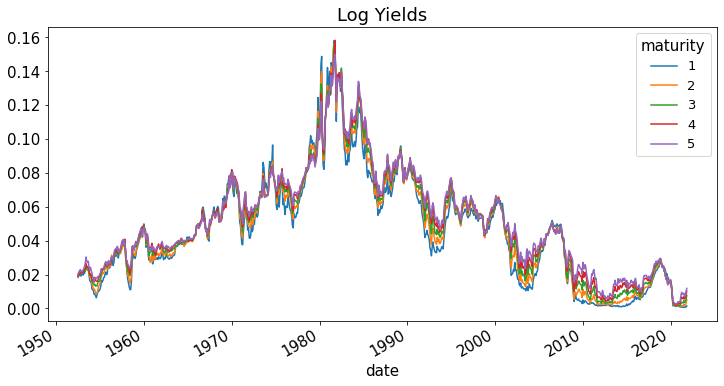

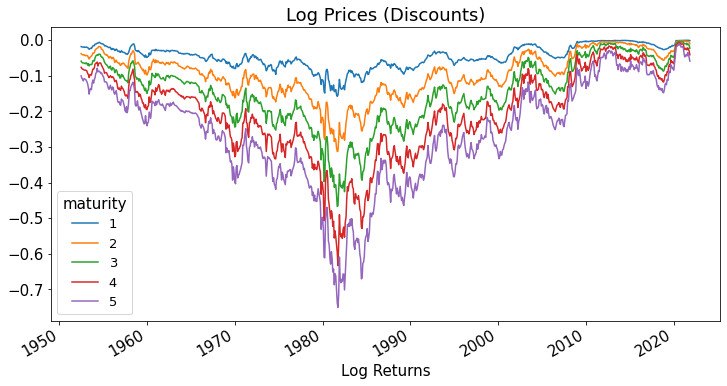

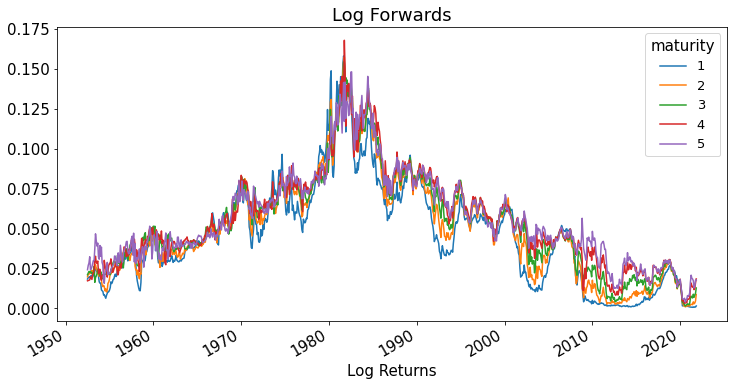

In [11]:
lyields.plot(title='Log Yields')
plt.show()
lprices.plot(title='Log Prices (Discounts)')
plt.show()
lforwards.plot(title = 'Log Forwards')
plt.show()

## Forward Rate Summary

The log forward rate of zero-coupon bonds has a simple formula:
$$\texttt{f}_t^{(n\to n+1)} \equiv \texttt{p}^{(n)}_t - \texttt{p}^{(n+1)}_t$$
Note that this is the difference
- across maturities
- not time
of the log prices.

For $n=0$, the log forward is simply:
$$\texttt{f}_t^{(0\to 1)} \equiv \texttt{p}^{(0)}_t - \texttt{p}^{(1)}_t =  - \texttt{p}^{(1)}_t =  \texttt{y}^{(1)}_t$$

## Data Note: Why are we only using maturities through 5 years?

Obviously there is no traded treasury that has a constant maturity of 1 year, 2 years, etc.

But for analysis, we would like an index showing the pricing of these maturities at any given date.

Building this index requires care, with rules on which issue of treasury to use as being closest to that maturity.

#### These are known as Constant Maturity Treasuries (CMT) - they are an index
- The most popular for research purposes are the Fama-Bliss construction. 
- Other series will give similar results for our work below!

#### Data Source:
Fama-Bliss Treasury discount bonds
- Screened treasuries to construct yield curve out to $T=5$.
- Reported at monthly frequency.
- Hypothetical zero-coupon bonds.

https://www.crsp.org/products/documentation/fama-bliss-discount-bonds-–-monthly-only